## Concise: 1: Start and mesh
Author: yanjun zhang, Source from book "Abali - 2017 - Computational Reality" P119

In [1]:
from disc_f import *

# mesh-size, contact area coefficient
mesh_min, mesh_max = 3, 5
c_contact          = 1
# Each time step rotation angular, and acc during lag, 1 is full acc, 0 is no acc.
angular_r          = 22400/2
v_vehicle, c_acc   = 160, 1
z1,z2,z3,z_all     = 20,33,30,8
pad_v_tag          = 32
# calling local functions to get all parameters
(dt, P, g, num_steps, h, radiation, v_angular, Ti, Tm, S_rub_circle, t, rho, c, k, t_brake, 
S_total,) = vehicle_initial (angular_r, v_vehicle, c_contact, c_acc)
print("1: Total braking tims is ", round(sum(dt), 2), "s")
print("2: Total numb steps is ", num_steps)

## here use lots of abbreviation, details are in disc_f
domain, cell_markers, facet_amrkers, mesh_name, mesh_name1, mesh_name2 \
                       = mesh_brake_all(mesh_min,mesh_max,pad_v_tag)
V, T_init, u_n         = initial_u_n(domain, Ti)
fdim, bc, mesh_brake, all_e,xdmf, x_co, y_co, ds, b_con \
                       = mesh_setup(domain, V,mesh_name1,num_steps, \
                         angular_r, mesh_name2, c_contact,z_all,Tm, S_rub_circle)
# Initialize
problem,u,v,f,n_vector = variation_initial(V, T_init,domain, rho, c, b_con,\
                          radiation, h, k, xdmf,dt,ds,u_n, Tm,g,bc);
n,converged = solver_setup_solve(problem,u)
## Visualization of time dependent problem using pyvista
gif_name    = "T-s-{}-d-{}-{}-c-{}-e-{}.gif".format(num_steps, angular_r, mesh_name2, c_contact, all_e)
plotter, sargs, renderer, warped, viridis, grid = plot_gif(V,u,gif_name)
##solve
#num_steps= int( num_steps/2 )
T_array     = solve_heat(Ti, u, num_steps, dt, x_co, y_co, angular_r,t_brake, \
                     domain,S_rub_circle,fdim, rho, c, v, radiation, k, h, \
                     f,Tm,u_n,g, ds, xdmf, b_con,bc,plotter,warped)
csv_name    = "Result_T-s-{}-d-{}-{}-c-{}-e-{}.csv".format(num_steps, angular_r, mesh_name2, c_contact, all_e  )
# got the Temperature data
save_t_T(csv_name, T_array)

DOLFINx version: 0.8.0
Simulation environment setup complete.
1: Total braking tims is  69.79 s
2: Total numb steps is  14
The file 'm-3-5.msh' exists, start creat now:
Info    : Reading 'm-3-5.msh'...
Info    : 168 entities
Info    : 57426 nodes
Info    : 271659 elements
Info    : Done reading 'm-3-5.msh'                                         

1: Progress: 142.4%. Use time: 0 hours 1 min. Start: 2024-10-24 09:26:50.       
t and T have been successfully saved as Result_T-s-14-d-11200.0-m-3-5-c-1-e-271659.csv


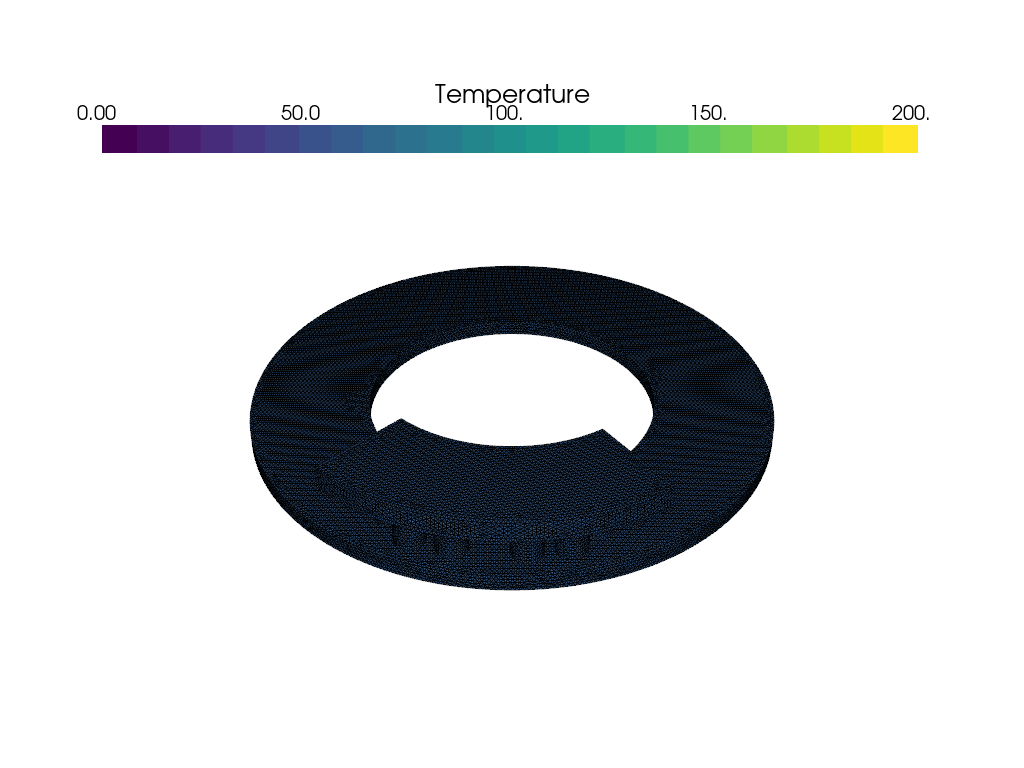

In [2]:
from IPython.display import display, Image
display(Image(gif_name))

# 2: New brake pad points, add boundary for rubbing elements

Info    : Reading 'm-3-5.msh'...
Info    : 168 entities
Info    : 57426 nodes
Info    : 271659 elements
Volume:, Tag:31] Reading elements                                          
Volume:, Tag:32
Info    : Done reading 'm-3-5.msh'        
Info    : Meshing 1D...
Info    : Done meshing 1D (Wall 0.00027741s, CPU 0.000164s)
Info    : Meshing 2D...
Info    : Done meshing 2D (Wall 0.00194969s, CPU 0s)
Info    : Meshing 3D...
Info    : Done meshing 3D (Wall 1.41541s, CPU 1.097s)
Info    : Optimizing mesh...
Info    : Done optimizing mesh (Wall 0.00993729s, CPU 0.0103s)
Info    : 57426 nodes 271707 elements
Info    : Writing 'new_pad.msh'...
Info    : Done writing 'new_pad.msh'
Info    : Reading 'm-3-5.msh'...
Info    : 168 entities
Info    : 57426 nodes
Info    : 271659 elements
Info    : Done reading 'm-3-5.msh'                                         
Info    : Reading 'new_pad.msh'...
Info    : 168 entities
Info    : 17025 nodes
Info    : 78227 elements
Info    : Done reading 'new_pad.msh

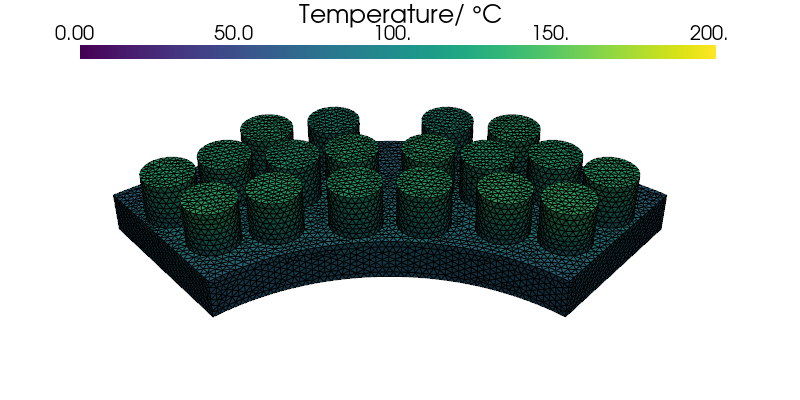

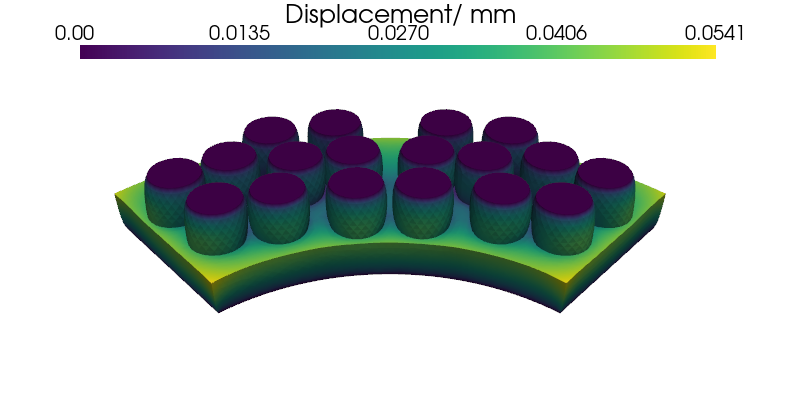

In [3]:
## plot the temperature
mesh_n_pad = mesh_del_disc(mesh_name1, "new_pad.msh")
T_new_p, pad_node_coordinates  = T_pad_transfer1( mesh_name1, mesh_n_pad, u_n, mesh_brake, pad_v_tag )
domain_pad, cell_mark_pad, facet_mark_pad = gmshio.read_from_msh( mesh_n_pad , MPI.COMM_WORLD, 0, gdim=3 )
plot_T_pad( domain_pad, T_new_p).show()

# defin the pad domain
VT      = fem.functionspace(domain_pad, ("CG", 1))    #define the finite element function space
Delta_T = fem.Function(VT, name ="Temperature_variation")  # T_ is the test function, like v
for i in range(len(T_new_p)):
    Delta_T.vector.array[i] = T_new_p[i]

#######try to make domain only for brake pad.
E    = fem.Constant(domain_pad, 50e3)             # Elastic module
nu   = fem.Constant(domain_pad, 0.2)             # Poission ratio
gdim = domain_pad.geometry.dim

mu    = E / 2 / (1 + nu)                      # Shear modulus
lmbda = E * nu / (1 + nu) / (1 - 2 * nu)   # Lame parameters
alpha = fem.Constant(domain_pad, 1e-5)         # Thermal expansion coefficient
f1    = fem.Constant(domain_pad, (0.0, 0.0, 0.0))       # O for external force

def eps(v):                                # epsilon, strain, the deforamtion, dy/y 
    return ufl.sym(ufl.grad(v))
def sigma(v, Delta_T):                     # sigmathis is sigma
    return (lmbda * ufl.tr(eps(v)) - alpha * (3 * lmbda + 2 * mu) * Delta_T 
    ) * ufl.Identity(gdim)  + 2.0 * mu * eps(v)     # here braces is important, can not be in above line

Vu = fem.functionspace(domain_pad, ("CG", 1, (gdim,))) 
du = ufl.TrialFunction(Vu)
u_ = ufl.TestFunction(Vu)

Wint = ufl.inner(sigma(du, Delta_T), eps(u_)) * ufl.dx  # here du is unkown
aM   = ufl.lhs(Wint)                                      # Wint is long and lhs can help to distinguish unkown and know.
LM   = ufl.rhs(Wint) + ufl.inner(f1, u_) * ufl.dx         # knows parameters are in lhs

def up_side(x):
    return np.logical_or(np.isclose(x[2], (z1)), np.isclose(x[2], (z1+z2+z3)))

up_dofs_u = fem.locate_dofs_geometrical(Vu, up_side) # lateral sides of domain
bcu       = [fem.dirichletbc(np.zeros((gdim,)), up_dofs_u, Vu)]  # displacement Vu is fixed in lateral sides

u_d     = fem.Function(Vu, name="Displacement")
problem = fem.petsc.LinearProblem(aM, LM, u=u_d, bcs=bcu)
problem.solve()

scale_factor = 100
plot_s_pad = plot_S_pad(Vu,u_d,scale_factor )
plot_s_pad.show()


# Add boundary, contains contact mechanics

Info    : Reading 'new_pad.msh'...
Info    : 168 entities
Info    : 17025 nodes
Info    : 78227 elements
Info    : Done reading 'new_pad.msh'


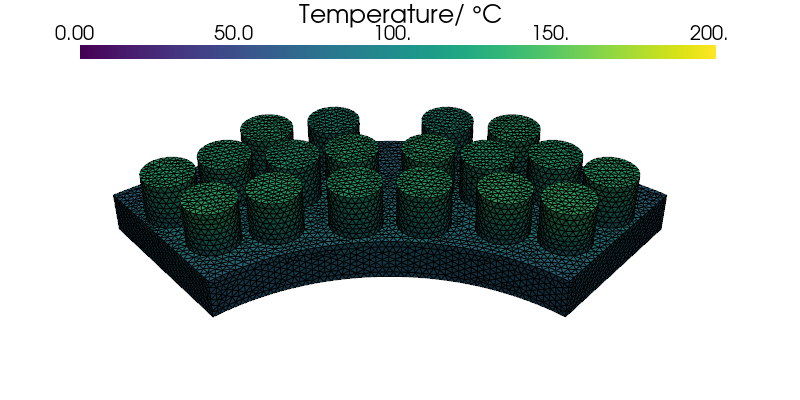

In [4]:
import dolfinx.fem as fem
import ufl
import numpy as np

# Define the domain and mesh (assuming these are already created)
domain_pad, cell_mark_pad, facet_mark_pad = gmshio.read_from_msh(mesh_n_pad, MPI.COMM_WORLD, 0, gdim=3)

# Define the function space
VT = fem.functionspace(domain_pad, ("CG", 1))  # Finite element space for temperature
Vu = fem.functionspace(domain_pad, ("CG", 1, (gdim,)))  # Function space for displacement vector field

# Define material parameters (assuming these are provided)
E = fem.Constant(domain_pad, 50e3)  # Elastic modulus
nu = fem.Constant(domain_pad, 0.2)  # Poisson's ratio
mu = E / (2 * (1 + nu))  # Shear modulus
lmbda = E * nu / ((1 + nu) * (1 - 2 * nu))  # Lame's first parameter
alpha = fem.Constant(domain_pad, 1e-5)  # Thermal expansion coefficient
f1 = fem.Constant(domain_pad, (0.0, 0.0, 0.0))  # No external force

# Temperature variation defined in the finite element space
Delta_T = fem.Function(VT, name="Temperature_variation")
for i in range(len(T_new_p)):
    Delta_T.vector.array[i] = T_new_p[i]

# Define strain and stress functions
def eps(v):  # Strain tensor
    return ufl.sym(ufl.grad(v))

def sigma(v, Delta_T):  # Stress tensor, includes thermal expansion
    return (lmbda * ufl.tr(eps(v)) - alpha * (3 * lmbda + 2 * mu) * Delta_T) * ufl.Identity(gdim) + 2.0 * mu * eps(v)

# Trial and test functions for displacement
du = ufl.TrialFunction(Vu)
u_ = ufl.TestFunction(Vu)

# Define the weak form (internal work)
Wint = ufl.inner(sigma(du, Delta_T), eps(u_)) * ufl.dx
aM = ufl.lhs(Wint)
LM = ufl.rhs(Wint) + ufl.inner(f1, u_) * ufl.dx  # Add external force (zero in this case)

# Boundary condition: Fix the displacement on z = (z1+z2+z3), lateral sides
def up_side(x):
    z_top = z1 + z2 + z3  # Modify as per your geometry
    return np.logical_or(np.isclose(x[2], z1*10), np.isclose(x[2], z_top))

up_dofs_u = fem.locate_dofs_geometrical(Vu, up_side)
bcu = [fem.dirichletbc(np.zeros((gdim,)), up_dofs_u, Vu)]  # Fix lateral sides (displacement zero)

# Solve the linear elasticity problem
u_d = fem.Function(Vu, name="Displacement")
problem = fem.petsc.LinearProblem(aM, LM, u=u_d, bcs=bcu)
problem.solve()

# Post-processing: enforce the z >= z1 constraint
u_d_vector = u_d.vector.array  # Get the displacement vector
z_coords = domain_pad.geometry.x[:, 2]  # Get the z-coordinates of the nodes

# Clip the displacement so that no node on z1 goes below z1
for i in range(len(z_coords)):
    if np.isclose(z_coords[i], z1):  # Check if the node is on the z1 plane
        if u_d_vector[i * gdim + 2] < 0:  # Check if the z-displacement is negative
            u_d_vector[i * gdim + 2] = 0  # Clip the z-displacement to zero

u_d.vector.array[:] = u_d_vector  # Update the displacement vector

# Post-processing: extract the solution or plot
# (Assuming you have a plot function implemented)
plot_T_pad(domain_pad, T_new_p).show()  # This shows the temperature plot (assuming this function exists)




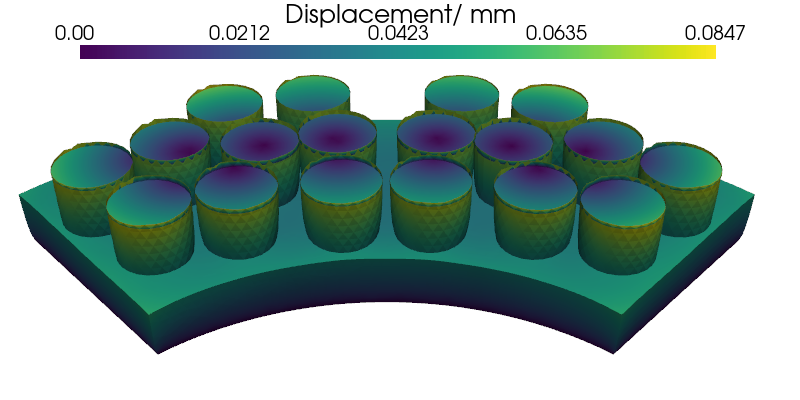

In [10]:

def plot_S_pad(Vu,u_d,scale_factor ):
    u_topology, u_cell_types, u_geometry = plot.vtk_mesh(Vu)        # get mesh data
    u_grid = pyvista.UnstructuredGrid(u_topology, u_cell_types, u_geometry) # plot grid
    u_3D = np.zeros((u_geometry.shape[0], 3))
    u_3D[:, :3] = u_d.x.array.reshape(-1, 3)
    u_grid.point_data["Displacement/ mm"] = u_3D

    u_grid.set_active_vectors("Displacement/ mm")
    warped = u_grid.warp_by_vector("Displacement/ mm", factor=scale_factor )
    plotter = pyvista.Plotter()
    plotter.window_size = (800, 400)
    sargs = dict(title_font_size=25, label_font_size=20,  color="black",
             position_x=0.1, position_y=0.85, width=0.8, height=0.1)

    plotter.add_mesh(warped, scalar_bar_args=sargs)
    plotter.camera.azimuth = -5
    plotter.camera.elevation = 180  
    plotter.zoom_camera(2) 
    return plotter
scale_factor = 100
plot_s_pad = plot_S_pad( Vu, u_d, scale_factor )
plot_s_pad.show()